# Introduction
Use this notebook to create box plots showing the dependence of expression on SNPs.

# Setup

In [1]:
import scanpy as sc
import pandas as pd
from IPython.display import display 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import collections
import re
from copy import copy
import seaborn as sns
import pickle as pkl
from functools import reduce
import anndata
import gzip
import pybedtools
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from scipy import stats
from scipy.spatial import distance
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import subprocess
import sys
import os
from nero import Hector as hct
from nero import utils as nrutils

In [2]:
mountpoint = '/data/clue/'
prefix_prod = mountpoint + 'prod/'
prefix_pks = mountpoint + 'amo/atac/peaks/'
prefix_eqtl = mountpoint + 'prod/eqtl/'

## Load in Data
Generated in other notebooks:

In [3]:
vcf = anndata.read_h5ad(prefix_eqtl + 'mateqtl/vcfs/vcf.h5ad')

In [4]:
with open(prefix_eqtl + 'mateqtl/pkls/pbulks.pkl', 'rb') as file:
    pbulks = pkl.load(file)

Choose which version of the data you'd like to plot:

In [5]:
# mateqtl_df = pd.read_pickle(prefix_eqtl + 'mateqtl/pkls/mateqtl_df.pkl')
mateqtl_df_haplo = pd.read_pickle(prefix_eqtl + 'mateqtl/pkls/mateqtl_df_haplo.pkl')

In [6]:
mat_df = mateqtl_df_haplo

In [7]:
mat_df.head()

,gene,statistic,pvalue,FDR,beta,cond,ct,BH,hg38_snps,hg19_snps,abs(beta),-log10FDR,-log10p,hg19_snp_chrom,hg19_snp_pos,BH_sig
snps,,,,,,,,,,,,,,,,
2:220200183,TUBA4A,inf,2.225074e-308,2.733331e-304,0.682570,G,pDC,4.884354e-08,2:219335461,2:220200183,0.682570,303.563308,307.652656,2,220200183,True
18:61033426,BCL2,inf,2.225074e-308,2.733331e-304,0.897114,G,pDC,3.924928e-08,18:63366193,18:61033426,0.897114,303.563308,307.652656,18,61033426,True
18:61038861,BCL2,inf,2.225074e-308,2.733331e-304,0.897114,G,pDC,3.890039e-08,18:63371628,18:61038861,0.897114,303.563308,307.652656,18,61038861,True
18:61040116,BCL2,inf,2.225074e-308,2.733331e-304,0.897114,G,pDC,3.855151e-08,18:63372883,18:61040116,0.897114,303.563308,307.652656,18,61040116,True
2:220177845,TUBA4A,inf,2.225074e-308,2.733331e-304,0.682570,G,pDC,4.814578e-08,2:219313123,2:220177845,0.682570,303.563308,307.652656,2,220177845,True


Import other metadata:

In [8]:
with open(mountpoint + 'meta.pkl', 'rb') as file:
    meta = pkl.load(file)

In [9]:
cond_cts = meta['eqtl']['cond_cts']
cts = cond_cts['ct'].cat.categories
ct_colors = meta['ct_colors']['ct5']['hex']
cond_colors = meta['cond_colors']['hex']
ct_idx_dict = dict([(v, k) for k, v in enumerate(cts)])
conds = meta['conds']['conds_filt']
stims = meta['conds']['conds_stims']

In [10]:
color_dicts={
    'ct': ct_colors,
    'cond': cond_colors,
}

## Functions

These functions help to generate all the plots.

In [11]:
def make_refalt(name_split):
    return {
        0.0: name_split[-2] + '/' + name_split[-2],
        1.0: name_split[-2] + '/' + name_split[-1],
        2.0: name_split[-1] + '/' + name_split[-1],
    }

In [12]:
def make_snp_s(snp):
    snp_ref_alt = vcf.obs_names[vcf.obs_names.str.contains(snp)][0]
    snp_s = pd.Series(vcf.var_vector(snp_ref_alt), index=vcf.var_names, name=snp_ref_alt)
    snp_s_name_split = snp_ref_alt.split(':')
    snp_s = snp_s.replace(make_refalt(snp_s_name_split))
    return snp_ref_alt, snp_s

In [129]:
def eqtl_box_plot(gene, order=None, snps=None, plot_stims=None, 
                  restrict=None, unique_FDR=None,
                  overlay_jitter=False, sort_by='-log10FDR', 
                  exclude_cts=[], include_cts=[],
                  num_plot=3, zthresh=False,
                  single=False, single_hue='ct'):
    '''
    Plot a box plot of pseudobulks showing the dependence of
    expression of a given gene on the top SNPs. You can directly
    supply `snps` to plot (chr:pos) or take the top `num_plot` SNPs
    from mat_df using `sort_by`; if the latter, you can choose to 
    restrict the search for top SNPs to certain conditions or cell types
    using `restrict_to`, and/or force reporting SNPs with unique FDR values
    (a heuristic to avoid reporting multiple perfectly linked SNPs, though
    if using mateqtl_df_haplo this is unnecessary). You can choose to 
    `exclude` or `include` certain cell types, and only plot certain stims 
    (`plot_stims`); by default, all will be plotted.
    
    You can also filter the plotted expression values by z score with 
    `zthresh`, useful when a few individuals have extreme expression values 
    that distort pltos with large y range. You can also choose to plot only 
    a single plot (`single`), which will plot all the available data points 
    on a single plot, using `single_hue` as the `hue` value in 
    `seaborn.boxplot`.
    
    '''
    
    if len(include_cts) == 0:
        include_cts = cts

    ct_order_dict = dict(zip(include_cts, range(len(include_cts))))
    

    if isinstance(order, type(None)):
        ct_plots = list(set(include_cts).difference({*exclude_cts}))
        ct_plots = sorted(ct_plots, key=lambda x: ct_order_dict[x])
    elif order in include_cts:
        ct_plots = [ct] + list(set(include_cts).difference({ct, *exclude_cts}))
        ct_plots = [ct_plots[0]] + sorted(ct_plots[1:], key=lambda x: ct_order_dict[x])
    else:
        assert False
        
    if isinstance(plot_stims, type(None)):
        cond_plots = ['C', 'G', 'B', 'R']
    else:
        cond_plots = plot_stims


    # print(geno_plot.iloc[:5])
    geno_plot = mat_df[mat_df['gene'] == gene].sort_values(by=sort_by, ascending=False)
    if not isinstance(restrict, type(None)):
        # must be a dict
        assert type(restrict) == dict
        for k in restrict:
            geno_plot = geno_plot[geno_plot[k].isin(restrict[k])]
    else:
        geno_plot = geno_plot[geno_plot['cond'].isin(cond_plots)]
    
    if unique_FDR:
        geno_plot = geno_plot[~geno_plot['FDR'].duplicated()]
    print('Number of SNPs for %s: %d' % (gene, geno_plot.shape[0]))
    
    if not isinstance(snps, type(None)):
        assert type(snps) == list
        num_plot = len(snps)
    for i in range(num_plot):
        try:
            if isinstance(snps, type(None)):
                row = geno_plot.iloc[i]
                snp = row.name
            else:
                row = geno_plot.loc[snps[i]]
                if len(row.shape) > 1:
                    row = row.iloc[0]
                snp = snps[i]
        except IndexError:
            break

        snp_ref_alt, snp_s = make_snp_s(snp)
        
        print(' | '.join(['GENE: ' + gene, 'SNP: ' + snp_s.name, 'COND: ' + row['cond'], 'CT: ' + row['ct'],
                          'FDR: ' + str(row['FDR']), 'beta: ' + str(row['beta'])]))
        if single:
            plt.figure(figsize=(4,4))
            plot_dfs = list()
            ct_conds = list(it.product(ct_plots, cond_plots))
            for ct_plot, cond_plot in ct_conds:
                plot_dfs.append(pd.concat([snp_s.astype('category'), pbulks[cond_plot][ct_plot].loc[gene].astype(np.float)], axis=1, join='inner'))
            data = pd.concat(plot_dfs, axis=0, keys=ct_conds, names=['ct', 'cond']).reset_index(['cond', 'ct'])
            if zthresh:
                keep_bool = (np.abs(stats.zscore(data[gene])) < zthresh)
                data = data[keep_bool]
                print("Number of removed outliers: %d" % (~keep_bool).sum())
            ax = sns.boxplot(data=data, x=snp_ref_alt, y=gene, hue=single_hue, palette=color_dicts[single_hue], linewidth=1, dodge=True, showfliers=False)
            if overlay_jitter:
                ax = sns.stripplot(data=data, x=snp_ref_alt, y=gene, hue=single_hue, 
                                   dodge=True, size=3, palette=color_dicts[single_hue], 
    #                                linewidth=0.5, edgecolors='gray', 
                                   ax=ax)

            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout()
            plt.show()
        else:
            fig_width = max(4, (3+(0.25)*len(cond_plots))*len(ct_plots)*0.8)
            fig, ax1 = plt.subplots(1, len(ct_plots), figsize=(fig_width,4), sharey=True)
            for j, (ct_plot, next_ax) in enumerate(zip(ct_plots, np.ravel(ax1))):

                plot_dfs = list()
                for cond_plot in cond_plots:
                    plot_dfs.append(pd.concat([snp_s.astype('category'), pbulks[cond_plot][ct_plot].loc[gene].astype(np.float)], axis=1, join='inner'))
                data = pd.concat(plot_dfs, axis=0, keys=cond_plots, names=['cond']).reset_index('cond')
                if zthresh:
                    keep_bool = (np.abs(stats.zscore(data[gene])) < zthresh)
                    try:
                        removed.append((~keep_bool).sum())
                    except NameError:
                        removed = list()
                        removed.append((~keep_bool).sum())
                    data = data[keep_bool]
                next_ax = sns.boxplot(data=data, x=snp_ref_alt, y=gene, hue='cond', 
                                      dodge=True, palette=[cond_colors[cond] for cond in cond_plots], 
                                      linewidth=0.5, showfliers=False,
                                      ax=next_ax);
                if overlay_jitter:
                    next_ax = sns.stripplot(data=data, x=snp_ref_alt, y=gene, hue='cond', dodge=True, s=3,
                                            palette=['k' , 'k'], ax=next_ax, alpha=0.5);
                
                legend = next_ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
                legend.set_visible(False)
                
                next_ax.text(0, 1.1, ct_plot, ha='left', va='top', fontweight='bold', color=ct_colors[ct_plot], transform=next_ax.transAxes)
                if j != 0:
                    next_ax.set_ylabel(None)
            if zthresh:
                print("Number of removed outliers: " + ', '.join([ct + ': ' + str(r) for ct, r in zip(ct_plots, removed)]))
            legend.set_visible(True)
            plt.tight_layout()
            plt.show()

# Plot

Define useful variables of groups of cell types.

In [65]:
lymphocytes = ['B_Mem', 'B_Naive', 'MAIT', 'NK', 'NK_CD16+', 'NK_CD56++', 'T4_EM', 'T4_Naive', 'T8_Mem', 'T8_Naive', 'T_Tox', 'T_gd']

myeloid = ['cM', 'ncM', 'cDC', 'pDC']

t_cells = ['T4_Naive', 'T8_Naive', 'T4_EM', 'T8_Mem', 'T_gd', 'MAIT', 'T_Tox']
t4s = ['T4_EM', 'T4_Naive']
t8s = ['T8_Naive', 'T8_Mem', 'MAIT']
t_tox = ['T8_Mem', 'MAIT', 'T_gd', 'T_Tox']

nks = ['NK_CD16+', 'NK_CD56++', 'NK']

b_cells = ['B_Mem', 'B_Naive']

P_specific = ['NK', 'T_Tox']

## Explore a Single Cell Type

Choose a cell type to focus on. 

In [244]:
ct_focus = 'B_Naive'

### Distribution of Significant eQTLs

Here we explore the number of significant eQTLs and the distribution of $-log_{10}(FDR)$ per eGene.

In [294]:
sub_mdh = mat_df[((mat_df['ct'] == ct_focus) & (mat_df['BH_sig']))]
val_counts_submdh = sub_mdh['gene'].value_counts().rename('counts')
val_counts_submdh.index.rename('gene', inplace=True)
val_counts_submdh = val_counts_submdh.reset_index()

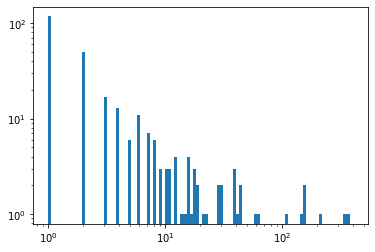

In [295]:
plt.hist(val_counts_submdh['counts'].values, bins=nrutils.make_logspace(1, 400, 100));
plt.xscale('log');
plt.yscale('log');

In [300]:
valcount_thresh = 5

In [301]:
filt_val_counts_submdh = val_counts_submdh[val_counts_submdh['counts'] >= valcount_thresh]
filt_val_counts_submdh.shape

(77, 2)

In [346]:
score_num = 3
plot_sig = '-log10FDR'
# plot_sig = '-log10p'

0it [00:00, ?it/s]

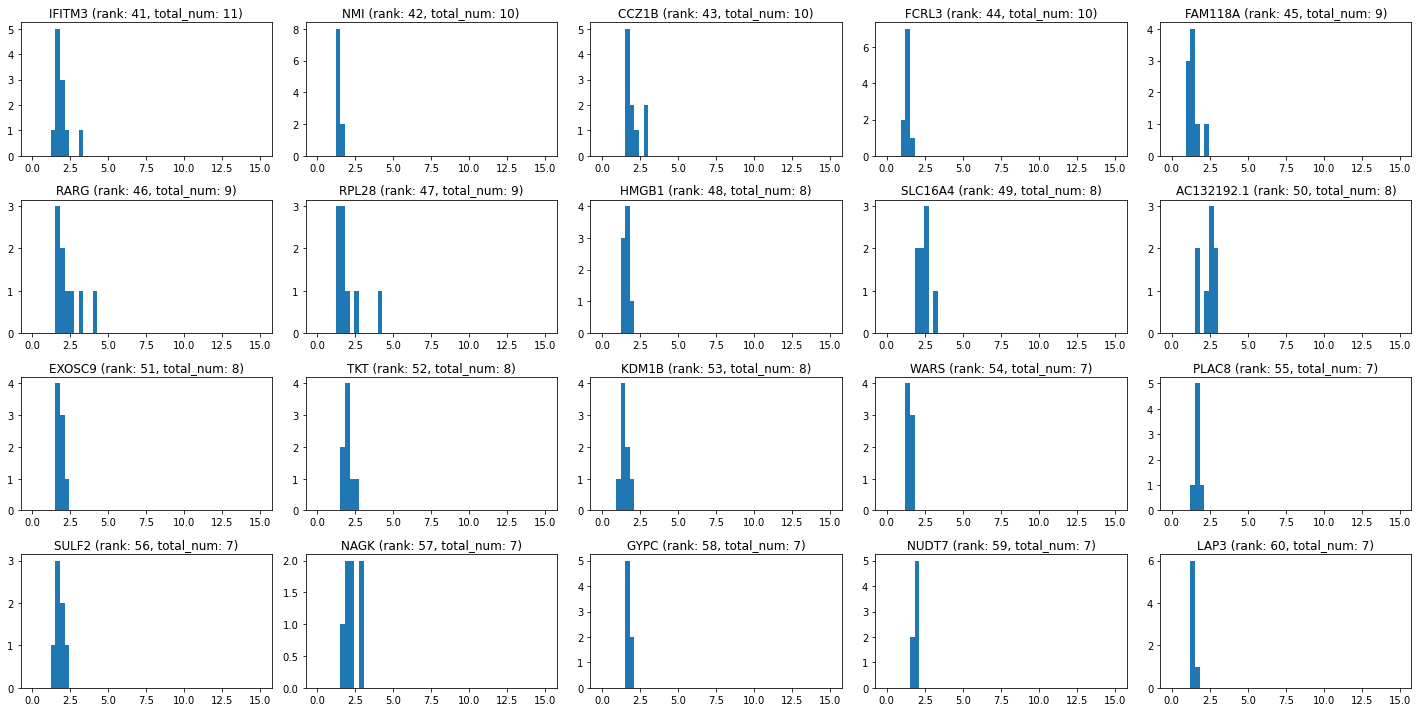

In [347]:
assert isinstance(score_num, int) and score_num > 0
fig, ax = plt.subplots(4, 5, figsize=(20, 10))
for (idx, (gene, count)), ax in tqdm(zip(filt_val_counts_submdh.head(20*score_num).tail(20).iterrows(), np.ravel(ax))):
    vals = sub_mdh[sub_mdh['gene'] == gene][plot_sig]
    ax.hist(vals, bins=np.linspace(0, 15, 50))
    ax.set_title(gene + ' (rank: %d, total_num: %d)' % (idx + 1, len(vals)))
plt.tight_layout()

In [352]:
gene = 'CCZ1B'

In [353]:
mat_df[(mat_df['gene'] == gene) & (mat_df['BH_sig'])
#            & (mat_df['FDR'] < 0.05)
#            & (mat_df['ct'] == ct_focus)
          ].sort_values(by='FDR').groupby(['cond', 'ct']).size().replace(0, np.nan).dropna()

cond  ct      
A     T4_Naive     7.0
      cM           1.0
B     T4_Naive     3.0
P     T4_Naive    11.0
      T8_Naive    11.0
R     B_Mem        5.0
      B_Naive     10.0
      T4_Naive    11.0
dtype: float64

### Plot

* `plot_stims` controls which stimulations are shown on each plot
* `num_plot` is the number of plots generated
* `zthresh` removes data points from each plot with a large zscore
* `restrict` restricts the SNPs shown to only those that are significant in the provided condition(s) and/or cell types(s)
* `unique_FDR` only shows sets of SNPs with unique FDR (usually indicating they are not perfectly linked)
* `sort_by` decides how you want to sort the SNPs to choose the top `num_plot` SNPs
* `(in/ex)clude_cts` restricts which cell types are shown, you must use these parameters (in particular when plotting PMA/I, since there are many cell types missing data for PMA/I since it was not run on most of the cell types that the other conditions were run on
* `overlay_jitter` overlays a jitter plot on the box plot

Number of SNPs for CCZ1B: 189
GENE: CCZ1B | SNP: 7:6869304:C:T | COND: R | CT: B_Naive | FDR: 0.0010755446902621301 | beta: -0.278511260739159


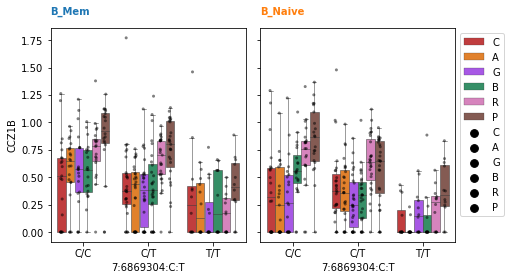

GENE: CCZ1B | SNP: 7:6885597:C:T | COND: R | CT: B_Naive | FDR: 0.00160011802473802 | beta: -0.264767724128978


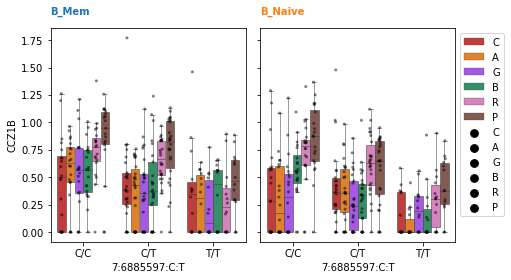

GENE: CCZ1B | SNP: 7:6881141:T:G | COND: R | CT: B_Naive | FDR: 0.006903616300650789 | beta: -0.257743031240544


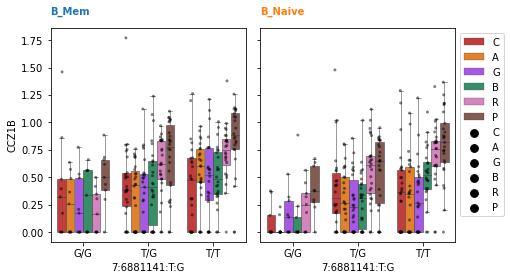

In [354]:
for g in [gene]:
    eqtl_box_plot(g, 
                  
#                   plot_stims=['C', 'A', 'B'], 
#                   plot_stims=['C', 'A', 'G', 'B', 'R'], 
                  plot_stims=['C', 'A', 'G', 'B', 'R', 'P'],
#                   plot_stims=['C', 'B', 'R'],                   
#                   plot_stims=['C', 'B', 'R'],                   
                  
                  num_plot=3,
                  
#                   zthresh=3,             
                  
                  restrict={'ct': [ct_focus]},
#                   restrict={'cond': ['B'], 'ct': [ct_focus]},
#                   restrict={'ct': ['cM']},                  
#                   
                  
#                   unique_FDR=True,
                  
#                   sort_by='abs(beta)',
                  
#                   include_cts = nks, # + t_tox,
#                   include_cts = ['NK_CD16+'] + t_tox,
                  include_cts = b_cells, # + ['cM', 'ncM'],# + t_tox + nks,

#                   exclude_cts = P_specific, 
                  
                  overlay_jitter=True,
                 );

Number of SNPs for RPS26: 195
GENE: RPS26 | SNP: 12:56401085:G:A | COND: R | CT: B_Naive | FDR: 2.47776314461906e-13 | beta: -0.0437975995996743


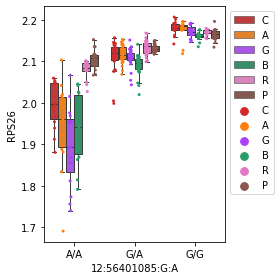

GENE: RPS26 | SNP: 12:56379427:G:C | COND: R | CT: B_Naive | FDR: 6.90916987641215e-11 | beta: 0.0430982612578078


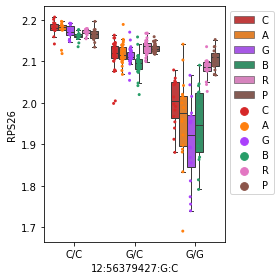

GENE: RPS26 | SNP: 12:56401085:G:A | COND: C | CT: B_Naive | FDR: 5.134388939603471e-10 | beta: -0.0983676469304906


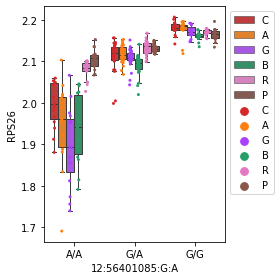

In [443]:
for g in [gene]:
    eqtl_box_plot(g, 
                  
#                   plot_stims=['C', 'A', 'B'], 
#                   plot_stims=['C', 'A', 'G', 'B', 'R'], 
                  plot_stims=['C', 'A', 'G', 'B', 'R', 'P'],
#                   plot_stims=['C', 'B', 'R'],                   
                  
                  num_plot=3,
                  
#                   zthresh=3,             
                  
                  restrict={'ct': [ct_focus]},
#                   restrict={'cond': ['B'], 'ct': [ct_focus]},
#                   restrict={'ct': ['cM']},                  
#                   
                  
#                   unique_FDR=True,
                  
#                   sort_by='abs(beta)',

                  include_cts = ['B_Naive'],
                  
                  overlay_jitter=True,
                  
                  single=True, single_hue='cond',
                 );

## Find Cell type- and Condition-Specific eQTLs

### Distribution of signifcant eQTLs across Groups

In [14]:
mateqtl_df_haplo_sig = mateqtl_df_haplo[mateqtl_df_haplo['BH_sig']].copy()

In [15]:
top_genes = dict()
for idx, (cond, ct) in cond_cts.iterrows():
    gene_counts = mateqtl_df_haplo_sig[((mateqtl_df_haplo_sig['ct'] == ct) & (mateqtl_df_haplo_sig['cond'] == cond))]['gene'].value_counts()
    top_genes[(cond, ct)] = gene_counts[gene_counts >= 1]

In [16]:
union_top_genes = reduce(np.union1d, [top_genes[k].index.tolist() for k in top_genes])

In [17]:
counts_per_condct = pd.DataFrame(0, columns=cond_cts, index=union_top_genes)

In [18]:
for (cond, ct) in tqdm(top_genes):
    for gene in top_genes[(cond, ct)].index:
        counts_per_condct.loc[gene, [(cond, ct)]] = top_genes[(cond, ct)].loc[gene]

  0%|          | 0/77 [00:00<?, ?it/s]

In [507]:
counts_per_condct['sum'] = counts_per_condct.sum(1)
counts_per_condct.sort_values(by='sum', ascending=False, inplace=True)
counts_per_condct.drop(columns=['sum'], inplace=True)

In [508]:
counts_per_condct = counts_per_condct.T.sort_index()
counts_per_condct.index = pd.MultiIndex.from_tuples(counts_per_condct.index, names=['cond', 'ct'])
counts_per_condct = counts_per_condct.reset_index()

In [511]:
counts_per_condct['cond_order'] = counts_per_condct['cond'].map(dict([(v, k) for (k, v) in enumerate(['C', 'A', 'G', 'B', 'R', 'P'])]))
counts_per_condct.sort_values(by=['cond_order', 'ct'], inplace=True)
counts_per_condct.drop(columns=['cond_order'], inplace=True)
counts_per_condct = counts_per_condct.T

Export here to explore in Excel if desired:

In [41]:
# counts_per_condct.to_csv(prefix_eqtl + 'mateqtl/vals/counts_per_condct.csv')
counts_per_condct = pd.read_csv(prefix_eqtl + 'mateqtl/vals/counts_per_condct.csv', header=[1, 2], index_col=0)

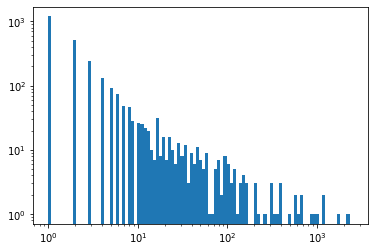

In [42]:
plt.hist(counts_per_condct.sum(1), bins=nrutils.make_logspace(1, 2500, 100));
plt.xscale('log')
plt.yscale('log');

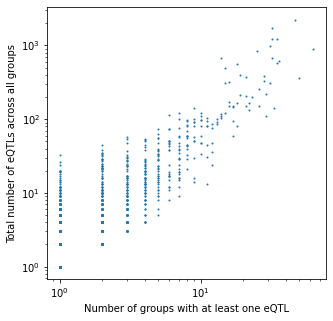

In [59]:
plt.figure(figsize=(5, 5))
num_groups = (counts_per_condct > 0).sum(1)
num_eqtls = counts_per_condct.sum(1)
plt.scatter(num_groups, num_eqtls, s=1);
plt.xlabel('Number of groups with at least one eQTL')
plt.ylabel('Total number of eQTLs across all groups')
plt.xscale('log')
plt.yscale('log');

Create `specific_counts` to explore the specific eQTLs.

In [204]:
# restrict = None
restrict = {'cond': ['G'], 'ct': ['B_Naive', 'B_Mem']}
with pd.option_context('display.max_rows', 150, 'display.max_columns', 80, 'display.max_colwidth', -1, 'display.multi_sparse', False):
    specific_counts = counts_per_condct[(num_groups <= 2) & (num_eqtls > 10)]
    if not isinstance(restrict, type(None)):
        keep_bool = specific_counts.columns.isin(values=restrict['ct'], level='ct') & specific_counts.columns.isin(values=restrict['cond'], level='cond')
        specific_counts = specific_counts.loc[:, keep_bool]
    display(specific_counts.loc[:,specific_counts.sum(0) > 0])

cond,G,G
ct,B_Mem,B_Naive
OAS1,0,0
XKR6,0,0
ASNSD1,0,0
UBE2F,0,0
THUMPD3-AS1,0,0
DNTTIP1,0,0
MED8,0,0
ACOX3,0,0
IPO5,0,0


### Plot Specific eQTLs

Number of SNPs for P2RX5: 513
GENE: P2RX5 | SNP: 17:3613741:A:T | COND: R | CT: B_Naive | FDR: 0.000361509538339442 | beta: 0.29630970115231203


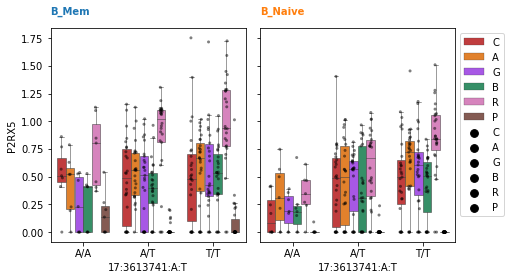

GENE: P2RX5 | SNP: 17:3607831:A:G | COND: R | CT: B_Naive | FDR: 0.000871717999210163 | beta: 0.283085404276524


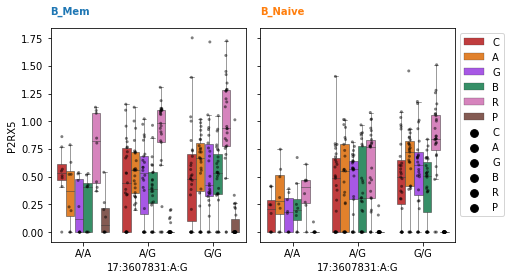

GENE: P2RX5 | SNP: 17:3616898:G:T | COND: R | CT: B_Naive | FDR: 0.00107873795436379 | beta: 0.260354589639283


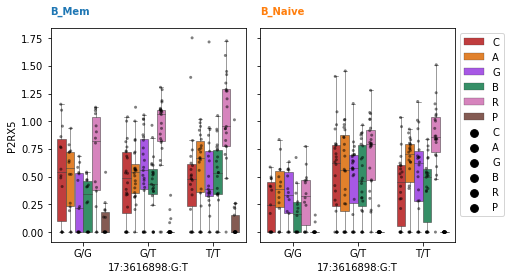

In [206]:
for g in ['P2RX5']:
    eqtl_box_plot(g, 
                  
#                   plot_stims=['C', 'G', 'B'], 
#                   plot_stims=['C', 'A', 'G', 'B', 'R'], 
                  plot_stims=['C', 'A', 'G', 'B', 'R', 'P'],
#                   plot_stims=['C', 'B', 'R'],                   
                  
                  num_plot=3,
                  
#                   zthresh=2.5,             
                  
                  restrict={'ct': ['B_Naive', 'B_Mem']},
#                   restrict={'cond': ['C']},# 'ct': [ct_focus]},
#                   restrict={'ct': ['T4_Naive']},                  
                  
                  
#                   unique_FDR=True,
                  
#                   sort_by='abs(beta)',

#                   include_cts = ['T4_Naive', 'T8_Naive', 'NK_CD16+', 'B_Naive', 'cM'],
#                   include_cts = t4s,
                  include_cts = b_cells,
#                   include_cts = ['cM'],                  
#                   include_cts = ['T4_Naive'],  
#                   include_cts = myeloid,                  
#                   include_cts = ['ncM'],
#                   include_cts = t_cells,
                  
                  exclude_cts = P_specific,
                  
                  overlay_jitter=True,
                  
#                   single=True, single_hue='cond',
                 );

### Make a "Specificity Figure"
A figure of 3 box plots showing the specificity of a certain eQTL in a certain cell-type and condition, as compared to other conditions of the same cell type and other cell types of the same condition.

In [213]:
def make_specificity_fig(gene, cond_groups, ct_groups, snp=None,
                         sharey=True,
                         plot_1=None,
                         plot_2=None,
                         plot_3={'split_cond':False, 'exclude_C': True, 
                                 'jitter':False, 'jit_colors': False, 'color_conds': False}
                        ):
    '''
    Still a lot of TODOs here for customizability.
    '''
    plot_opts = {
        '1': {},
        '2': {},
        '3': {'split_cond':False, 'exclude_C': True, 'jitter':False, 'jit_colors': False, 'color_conds': False}
    }
    for k in set(plot_opts['3'].keys()).difference(plot_3.keys()):
        plot_3.update({k: plot_opts['3'][k]})
    
    if plot_3['color_conds']:
        assert len(ct_groups[1]) == 1, "Can't set color_conds=True for plot_3 with len(ct_groups[1]) > 1"
    if plot_3['exclude_C'] and ('C' not in cond_groups[0]):
        plot_3['exclude_C'] = False
    
    geno_plot = mat_df[(mat_df['cond'].isin(cond_groups[0])) & 
                       (mat_df['ct'].isin(ct_groups[0])) & 
                       (mat_df['gene'] == gene)].copy()
    if type(snp) == int:
        row = geno_plot.iloc[snp]
    elif type(snp) == str:
        row = geno_plot.loc[snp]
    elif type(snp) == tuple:
        assert len(snp) == 2, 'If type(snp)==tuple, must be of length 2 for column, value in mat_df'
        row = geno_plot[geno_plot[snp[0]] == snp[1]].iloc[0]
    elif type(snp) == type(None):
        row = geno_plot.iloc[0]
        
    print(row)
    snp_ref_alt, snp_s = make_snp_s(row.name)
    fig, ax = plt.subplots(2, 2, figsize=(5,5), sharey=sharey)

    # Plot 1
    plot_dfs = list()
    for ct_plot, cond_plot in it.product(ct_groups[0], cond_groups[0]):
        plot_dfs.append(pd.concat([snp_s.astype('category'), pbulks[cond_plot][ct_plot].loc[gene].astype(np.float)], axis=1, join='inner'))
    data = pd.concat(plot_dfs, axis=0, keys=cond_groups[0], names=['cond']).reset_index('cond')
    ax[0, 0]  = sns.boxplot(data=data, x=snp_ref_alt, y=gene, hue='cond', 
                          dodge=True, palette=[cond_colors[c] for c in cond_groups[0]], 
                          linewidth=1, showfliers=False,
                          ax=ax[0, 0] );
    ax[0, 0]  = sns.stripplot(data=data, x=snp_ref_alt, y=gene, hue='cond', dodge=True, s=3,
                            palette=['k' , 'k'], ax=ax[0, 0] , alpha=0.5);
    ax[0, 0] .legend().set_visible(False)



    # Plot 2
    plot_dfs = list()
    for ct_plot, cond_plot in it.product(ct_groups[0], cond_groups[1]):
        plot_dfs.append(pd.concat([snp_s.astype('category'), pbulks[cond_plot][ct_plot].loc[gene].astype(np.float)], axis=1, join='inner'))
    data = pd.concat(plot_dfs, axis=0, keys=cond_groups[1], names=['cond']).reset_index('cond')

    ax[0, 1]  = sns.boxplot(data=data, x=snp_ref_alt, y=gene, hue='cond',
                            palette=[cond_colors[cond_plot] for cond_plot in cond_groups[1]], #width=0.5, 
                            linewidth=1, showfliers=False, ax=ax[0, 1]);
    ax[0, 1]  = sns.stripplot(data=data, x=snp_ref_alt, y=gene, hue='cond', dodge=True, s=2,
                            color='k', ax=ax[0, 1]);
    ax[0, 1] .legend().set_visible(False)



    # Plot 3
    plot_dfs = list()
    if plot_3['exclude_C']:
        cond_groups[0].remove('C')
    
    for ct_plot, cond_plot in it.product(ct_groups[1], cond_groups[0]):
        plot_dfs.append(pd.concat([snp_s.astype('category'), pbulks[cond_plot][ct_plot].loc[gene].astype(np.float)], axis=1, join='inner'))
    data = pd.concat(plot_dfs, axis=0, keys=it.product(ct_groups[1], cond_groups[0]), names=['ct', 'cond']).reset_index(['ct', 'cond'])
    
    if plot_3['color_conds']:
        ax[1, 0]  = sns.boxplot(data=data, x=snp_ref_alt, y=gene, hue='cond',
                                palette=[cond_colors[cond_plot] for cond_plot in cond_groups[0]], #width=0.5, 
                                linewidth=1, showfliers=False, ax=ax[1, 0]);
    else:
        ax[1, 0]  = sns.boxplot(data=data, x=snp_ref_alt, y=gene, hue='ct',
                                palette=[ct_colors[ct_plot] for ct_plot in ct_groups[1]], #width=0.5, 
                                linewidth=1, showfliers=False, ax=ax[1, 0]);
        
    if plot_3['jitter']:
        for cond_plot in cond_groups[0]:
            if plot_3['jit_colors']:
                ax[1, 0]  = sns.stripplot(data=data[data['cond'] == cond_plot], x=snp_ref_alt, y=gene, hue='ct', dodge=True, 
                                          s=3, palette=[cond_colors[cond_plot]]*len(ct_groups[1]), ax=ax[1, 0]);
            else:
                ax[1, 0]  = sns.stripplot(data=data[data['cond'] == cond_plot], x=snp_ref_alt, y=gene, hue='ct', dodge=True, 
                                          s=3, color='k', ax=ax[1, 0]);



                
    
    ax[1, 0].legend().set_visible(False)

    ax[1,1].set_visible(False)

    plt.tight_layout()

gene                    UBE2F
statistic            -8.44021
pvalue            1.13841e-10
FDR               1.56358e-06
beta                -0.208844
cond                        B
ct                         cM
BH                2.69616e-06
hg38_snps         2:238008106
hg19_snps         2:238916748
abs(beta)            0.208844
-log10FDR             5.80588
-log10p                9.9437
hg19_snp_chrom              2
hg19_snp_pos        238916748
BH_sig                   True
Name: 2:238916748, dtype: object


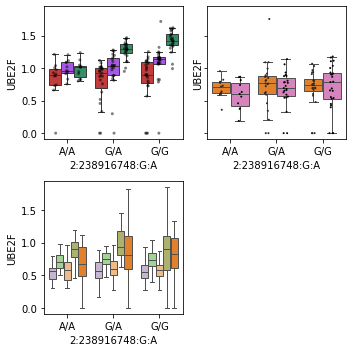

In [188]:
cond_groups = [['C', 'G', 'B'], ['A' , 'R']]

# ct_groups = [['myeloid_cells'], ['T4_Naive', 'T8_Naive', 'T4_Mem', 'NK_T_Tox', 'B_cells']].
ct_groups = [['cM'], ['T8_Naive', 'T4_Naive', 'T4_EM', 'NK_CD16+', 'B_Naive']]

gene = 'UBE2F'
make_specificity_fig(gene, cond_groups, ct_groups)

gene                   PPP1CB
statistic            -5.58614
pvalue            1.06797e-06
FDR               0.000657152
beta               -0.0457789
cond                        P
ct                   T4_Naive
BH                1.33451e-05
hg38_snps          2:28886765
hg19_snps          2:29109631
abs(beta)           0.0457789
-log10FDR             3.18233
-log10p               5.97144
hg19_snp_chrom              2
hg19_snp_pos         29109631
BH_sig                   True
Name: 2:29109631, dtype: object


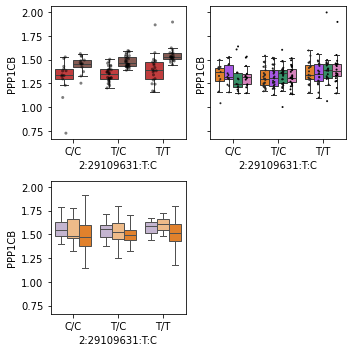

In [191]:
cond_groups = [['C', 'P'], ['A' , 'G', 'B', 'R']]

# ct_groups = [['myeloid_cells'], ['T4_Naive', 'T8_Naive', 'T4_Mem', 'NK_T_Tox', 'B_cells']].
ct_groups = [['T4_Naive'], ['T8_Naive', 'T4_EM', 'B_Naive']]

gene = 'PPP1CB'
make_specificity_fig(gene, cond_groups, ct_groups)

gene                    P2RX5
statistic             6.36648
pvalue            7.48831e-08
FDR                0.00036151
beta                  0.29631
cond                        R
ct                    B_Naive
BH                 7.9929e-06
hg38_snps          17:3710447
hg19_snps          17:3613741
abs(beta)             0.29631
-log10FDR             3.44188
-log10p               7.12562
hg19_snp_chrom             17
hg19_snp_pos          3613741
BH_sig                   True
Name: 17:3613741, dtype: object


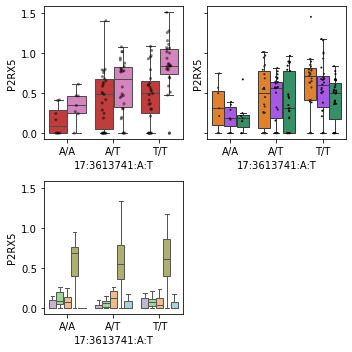

In [211]:
cond_groups = [['C', 'R'], ['A' , 'G', 'B']]

# ct_groups = [['myeloid_cells'], ['T4_Naive', 'T8_Naive', 'T4_Mem', 'NK_T_Tox', 'B_cells']].
ct_groups = [['B_Naive'], ['T8_Naive', 'T4_Naive', 'T4_EM', 'NK_CD16+', 'cM']]

gene = 'P2RX5'
make_specificity_fig(gene, cond_groups, ct_groups)